In [2]:
import ipywidgets
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
# %load cheb.py
from numpy import *
from numpy.fft import fft,ifft

def cheb(y):
    '''Chebyshev transform. Finds Chebyshev coefficients given y evaluated on
    Chebyshev grid'''
    N = len(y) - 1
    yt = real(fft(r_[y,y[-2:0:-1]]))
    yt = yt/(2*N)
    yt = r_[yt[0],yt[1:N]+yt[-1:N:-1],yt[N]]

    return yt

def icheb(c):
    '''Inverse Chebyshev transform. Evaluates Chebyshev series at the Chebyshev 
    grid points given Chebyshev coefficients.'''
    N = len(c) - 1
    y = r_[c[0],0.5*c[1:N],c[N],0.5*c[-1:N:-1]]
    y = y*2*N
    y = real(ifft(r_[y,y[-2:0:-1]]))[:N+1]

    return y


def Dcheb(y,interval):
    '''Chebyshev derivative of y evaluated on Chebyshev grid in interval [a,b]'''
    N = len(y) - 1
    a,b = interval
    x = 0.5*(b-a)*(cos(r_[0:N+1]*pi/N) + 1) + a

    k = r_[0:N]

    A = real(fft(r_[y,y[-2:0:-1]]))
    yy = real(ifft(1j*r_[k,0,-k[-1:0:-1]]*A))

    fact = 2.*(x-a)/(b-a)-1
    fact = fact[1:-1]
    yprime = -2./(b-a)*yy[1:N]/sqrt(1-fact**2)

    A = A/(2*N)
    A = r_[A[0],A[1:N]+A[-1:N:-1],A[N]]
    k = r_[0:N+1]

    yprime1 = sum(k**2*A)*2./(b-a)
    yprimeN = sum((-1)**(k+1)*k**2*A)*2./(b-a)

    return r_[yprime1,yprime,yprimeN]



def regrid(y,M):
    N = len(y) - 1
    a = cheb(y)
    if M==N:
        return y
    if M>N:
        a = r_[a,zeros(M-N)]
        return icheb(a)
    if M<N:
        a = a[:M+1]
        return icheb(a)



def clenshaw(x,c):
    '''Clenshaw algorithm to evaluate Chebyshev series at x
    assumes x is in [-1,1]'''
    N = len(c) - 1
    b = zeros(N+2)
    b[-1] = 0
    b[-2] = c[-1]
    for r in r_[N-1:0:-1]:
        b[r] = 2*x*b[r+1] - b[r+2] + c[r]
    s = x*b[1] - b[2] + c[0]

    return s


def clenshaw2(x,c,change_grid = True):
    '''Vectorized version of Clenshaw algorithm
    Use this for Chebyshev polynomial evaluation'''
    if change_grid:
    	if (min(x)!=-1) or (max(x)!=1):
        	x = 2*(x-min(x))/(max(x)-min(x)) - 1
    N = len(c) - 1
    b = zeros([N+2,len(x)])
    b[-1,:] = 0
    b[-2,:] = c[-1]
    for r in r_[N-1:0:-1]:
        b[r,:] = 2*x*b[r+1,:] - b[r+2,:] + c[r]
    s = x*b[1,:] - b[2,:] + c[0]

    return s



def chebD(c,interval):
    '''Finds derivative of Chebyshev series in spectral space
    i.e. maps c_n--->d_n where c_n,d_n are Chebyshev coefficients
    of f(x) and f'(x) in the interval [a,b].'''
    N = len(c) - 1
    a,b = interval
    if (a!=-1.) or (b!=1.):
        factor = 2./(b-a)
    else: 
        factor = 1.

    b = c*r_[0:N+1]


    cp = zeros_like(b)

    cp[0] = sum(b[1::2])

    evens = b[2::2]
    odds = b[1::2]

    cp[1:N+1-(N%2):2] = 2*cumsum(evens[-1::-1])[-1::-1]
    cp[2:N+1-((N+1)%2):2] = 2*cumsum(odds[-1::-1])[-2::-1]

    cp = cp*factor

    return cp


def chebD_semiinf(c):
    '''Finds the derivative of Chebyshev series in spectral space
    i.e. maps c_n --> d_n where c_n, d_n are Chebyshev coefficients
    of f(x) and f'(x) in the interval [0,oo)'''
    '''To be used only for the positive half-line'''
    
    N = len(c) - 1
    
    b = c*r_[0:N+1]


    cp = zeros_like(b)

    cp[0] = sum(b[1::2])

    evens = b[2::2]
    odds = b[1::2]

    cp[1:N+1-(N%2):2] = 2*cumsum(evens[-1::-1])[-1::-1]
    cp[2:N+1-((N+1)%2):2] = 2*cumsum(odds[-1::-1])[-2::-1]

    d0 = 3./4*cp[0] - cp[1]/2. + cp[2]/8.
    d1 = -cp[0] + 7./8*cp[1] - cp[2]/2. + cp[3]/8.
    d2 = cp[0]/4. - cp[1]/2. + 3./4*cp[2] - cp[3]/2. + cp[4]/8.
    d3 = cp[1]/8. - cp[2]/2. + 3./4*cp[3] - cp[4]/2. + cp[5]/8.
    
    dn = [ cp[i-2]/8. - cp[i-1]/2. + 3./4*cp[i] - cp[i+1]/2. + cp[i+2]/8.  for i in range(4,N-1)]

    dn1 = cp[N-1-2]/8. - cp[N-1-1]/2. + 3./4*cp[N-1] - cp[N-1+1]/2.
    
    dn2 = cp[N-2]/8. - cp[N-1]/2. + 3./4*cp[N]
    
    dn = r_[d0,d1,d2,d3,dn,dn1,dn2]

    return dn


def cheb2zD_semiinf(c):
    '''Finds the Chebyshev coefficients of the operator 2z df/dz when
    f has a series in Chebyshev rational functions Rn(z) = Tn((z-1)/(z+1)). Input
    is the coefficients of f.'''
    
    N = len(c) - 1
    
    b = c*r_[0:N+1]


    cp = zeros_like(b)

    cp[0] = sum(b[1::2])

    evens = b[2::2]
    odds = b[1::2]

    cp[1:N+1-(N%2):2] = 2*cumsum(evens[-1::-1])[-1::-1]
    cp[2:N+1-((N+1)%2):2] = 2*cumsum(odds[-1::-1])[-2::-1]

    d0 = -cp[2]/4. + cp[0]/2.
    d1 = cp[1]/4. - cp[3]/4.
    d2 = -cp[0]/2. + cp[2]/2. - cp[4]/4.
    
    dn = [ -cp[n-2]/4.  + cp[n]/2. - cp[n+2]/4 for n in range(3,N-1)] 
    
    dn1 = -cp[N-3]/4. + cp[N-1]/2
    dn2 = -cp[N-2]/4. + cp[N]/2
    
    dn = r_[d0,d1,d2,dn,dn1,dn2]
    
    return dn



def Intcheb(y,interval):
    '''Clenshaw-Curtis to find definite integral of function y(x) given at
    Chebyshev grid points in some interval [a,b]'''
    fact = 0.5*(interval[1]-interval[0])
    b = cheb(y)
    N = len(y) - 1
    if N%2 == 0:
        w = array([ 2./(-(2*k)**2+1) for k in r_[0:N/2+1]])
    else:
        w = array([ 2./(-(2*k)**2+1) for k in r_[0:(N-1)/2+1]])
    return dot(b[::2],w)*fact



def chebI(c,interval,x0=None,f0=None):
    if x0==None:
        x0=interval[0]

    N = len(c) - 1
    I = diag(1./(2*r_[0.5,r_[2:N+1]]),-1) -diag(1./(2*r_[1,r_[1:N]]),1)
    I[0,1] = 0
    
    factor = (interval[1]-interval[0])/2.
    
    ci = dot(I,c)*factor
    x = 2*(x0-interval[0])/(interval[1]-interval[0]) - 1
    
    if x==-1 and f0==None:
        ci[0] = -sum((-1)**r_[1:N+1]*ci[1:])
    else:
        ci[0] = f0 - clenshaw(x,ci)
    return ci



def cheb_convolve(a,b):
    '''Finds the product of two functions whose Chebyshev coefficients are 
    given by a and b. Output is the coefficiets of the product.'''

    M = len(b)
    N = len(a)
    
    if N>M:
        b = r_[b,zeros(N-M)]
        N = N - 1
    elif M>N:
        a = r_[a,zeros(M-N)]
        N = M - 1
    else:
        N = N - 1
    
    a[0] = a[0]*2.
    b[0] = b[0]*2.
        
    c0 = a[0]*b[0] + 2*dot(a[1:],b[1:])
    
    c1 = [ dot(a[0:k+1][::-1],b[0:k+1]) + dot(a[1:N-k+1],b[k+1:N+1]) + dot(a[k+1:N+1],b[1:N-k+1])  for k in range(1,N) ]

    c2 = [ dot(a[k-N:N+1][::-1],b[k-N:N+1])  for k in range(N,2*N+1)]
    
    c = r_[c0/2,c1,c2]/2.
    
    return c[:N+1]
    
def cosT(d,inverse=False):
    '''Finds the cosine transform of a given sequence'''
    b = []
    N = len(d)-1
    for n in r_[0:N+1]:
        b.append(sum(d*cos(n*r_[0:N+1]*pi/N)))
    b = array(b)
    if inverse:
        return b
    else:
        b[0] = b[0]/(N)
        b[1:] = b[1:]*2/(N)
        return b

In [4]:
def cintmatrix(N, interval=[-1,1]):
    A=np.eye(N)
    B=np.zeros((N,N))
    i=0
    for row in A:
        B[i,:]= chebI(chebI(row,interval),interval)
        i+=1
    T=B.transpose() 
    return T

In [5]:
def loader(i,N):
    e = np.zeros(N)
    e[i] = 1
    j=np.empty((N,))
    j[::2]=1
    j[1::2]=-1
    p = chebI(chebI(e,[-1,1],-1,0),[-1,1],1,0)
    return dot(p,j)

In [40]:
q=loader(3,100)
q

-0.40000000000000002

In [6]:
N=100
i=1
e = np.zeros(N)
e[i] = 1
j=np.empty((N,))
j[::2]=1
j[1::2]=-1
s= chebI(e,[-1,1],-1,0)
r= chebI(s,[-1,1],1,0)
p = chebI(chebI(e,[-1,1],-1,0),[-1,1],1,0)
dot(p,j)

0.66666666666666663

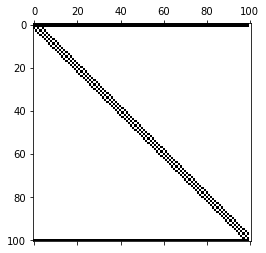

In [7]:
N=100
e = np.zeros(N)
e[1] = 1
e[0] =-1
I=np.identity(N)
B = np.zeros((N+1,N+1))
B[0:N,0:N]=I
B[0:N,-1]=e
B[-1,-1]=2
Int= cintmatrix(N)
A = np.zeros((N+1,N+1))
A[0:N,0:N]=Int
k = np.ones(N)
w= ones(N)
for i in range(N):
    w[i] = loader(i,1000) 
A[-1,0:N]=w
spy(A)

In [8]:
import scipy.linalg as p

In [9]:
lam= p.eigvals(A,B)

In [10]:
lam

array([ -7.36088186e-01 +0.00000000e+00j,
        -4.05284735e-01 +0.00000000e+00j,
        -4.71724545e-02 +0.00000000e+00j,
        -4.50316372e-02 +0.00000000e+00j,
        -1.64792729e-02 +0.00000000e+00j,
        -1.62113894e-02 +0.00000000e+00j,
        -8.34019551e-03 +0.00000000e+00j,
        -8.27111703e-03 +0.00000000e+00j,
        -5.02869748e-03 +0.00000000e+00j,
        -5.00351524e-03 +0.00000000e+00j,
        -3.36072353e-03 +0.00000000e+00j,
        -3.34946062e-03 +0.00000000e+00j,
        -2.40390171e-03 +0.00000000e+00j,
        -2.39813452e-03 +0.00000000e+00j,
        -1.80451688e-03 +0.00000000e+00j,
        -1.80126549e-03 +0.00000000e+00j,
        -1.40433919e-03 +0.00000000e+00j,
        -1.40236932e-03 +0.00000000e+00j,
        -1.12393444e-03 +0.00000000e+00j,
        -1.12267239e-03 +0.00000000e+00j,
        -9.19858495e-04 +0.00000000e+00j,
        -9.19013004e-04 +0.00000000e+00j,
        -7.66721200e-04 +0.00000000e+00j,
        -7.66133714e-04 +0.0000000

In [17]:
for i in range(1,20):
    l=1/(i)**2
    print(4*l/np.pi**2)

0.4052847345693511
0.10132118364233778
0.04503163717437234
0.025330295910584444
0.016211389382774045
0.011257909293593086
0.008271117032027573
0.006332573977646111
0.005003515241596927
0.004052847345693511
0.003349460616275629
0.0028144773233982714
0.002398134524079001
0.0020677792580068933
0.0018012654869748938
0.0015831434944115277
0.001402369323769381
0.0012508788103992319
0.0011226723949289503


In [ ]:
1/lam

array([ -1.35853288e+00 -0.00000000e+00j,
        -2.46740110e+00 -0.00000000e+00j,
        -2.11988121e+01 -0.00000000e+00j,
        -2.22066099e+01 -0.00000000e+00j,
        -6.06822889e+01 -0.00000000e+00j,
        -6.16850275e+01 -0.00000000e+00j,
        -1.19901266e+02 -0.00000000e+00j,
        -1.20902654e+02 -0.00000000e+00j,
        -1.98858652e+02 -0.00000000e+00j,
        -1.99859489e+02 -0.00000000e+00j,
        -2.97554973e+02 -0.00000000e+00j,
        -2.98555533e+02 -0.00000000e+00j,
        -4.15990385e+02 -0.00000000e+00j,
        -4.16990786e+02 -0.00000000e+00j,
        -5.54164947e+02 -0.00000000e+00j,
        -5.55165248e+02 -0.00000000e+00j,
        -7.12078684e+02 -0.00000000e+00j,
        -7.13078918e+02 -0.00000000e+00j,
        -8.89731610e+02 -0.00000000e+00j,
        -8.90731797e+02 -0.00000000e+00j,
        -1.08712373e+03 -0.00000000e+00j,
        -1.08812389e+03 -0.00000000e+00j,
        -1.30425505e+03 -0.00000000e+00j,
        -1.30525518e+03 -0.0000000